# Introducción a Machine Learning en Salud - Diabetes (Parte 2 de 2)

Juan Carlos Rincón Acuña, Ph.D.

El objetivo principal de Machine Learning (ML) es predecir o describir el comportamiento de elementos medibles de la realidad a partir de información incompleta e incierta.

Las condiciones de información incompleta e incierta hacen que modelos de las ciencias naturales no sean aplicables. Por eso gran parte de los métodos de ML estarán basados en intuiciones estadísticas y métodos computacionales.

La correlación de variables debe ser guiada por expertos, los cuales determinan, desde el punto de vista científico, el soporte de una relación entre variables. Esto es fundamental, dado que para la máquina, una variable es solo un número. 

En esta segunda parte, vamos a entrenar algoritmos para que predigan diabetes, en pacientes que no pertenecen a la base de datos.

## Cadena de procesos en ML - O.S.E.M.N.
* O - Obtaining; Obtener datos
* S - Scrubbing; Limpiar los datos
* E - Exploring; Visualizar los datos para encontrar patrones y relaciones. *Muchas veces este paso es transversal, en especial con (S)*
* M - Modeling; Modelar los datos para predecir o describir un comportamiento
* N - INterpreting; Interpretar los resultados de los modelos

![](https://miro.medium.com/max/3870/1*eE8DP4biqtaIK3aIy1S2zA.png)


### *En este vamos a realizar técnicas de Modelamiento (Entrenamiento) e Interpretación de los resultados.*

In [1]:
# Librerias necesarias
# Gestion de datos
import numpy as np
import pandas as pd
import seaborn as sns

# Tratamiento de datos
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split

# Visualización - Graficas
import matplotlib.pyplot as plt
import missingno as msno
from mlxtend.plotting import plot_decision_regions
#from sklearn.metrics import plot_confusion_matrix
from IPython.display import display

# Modelamiento
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,accuracy_score,roc_curve,roc_auc_score

# Valores iniciales
import warnings
warnings.filterwarnings('ignore') # Ignorar advertencias
%matplotlib inline
sns.set()

## Modelamiento

Antes de empezar a entrenar los modelos, es necesario tener en cuenta ciertas técnicas que permitiran evaluar e interpretar de mejor manera los resultados de los modelos.

Una de las técnicas y quizas la mas importante para validar resultados es **Dividir los datos (Data-Split)**.

### Data Split: Entrenamiento-Pruebas (Train-Test) y Validación Cruzada (Cross Validation)

- **Train-Test:** Siempre es bueno contar con datos desonocidos para el modelo (diferentes con los que sería entrenado) para probar su desempeño, en lugar de probar con los mismos con los que fue entrenado.

![](https://upload.wikimedia.org/wikipedia/commons/4/48/Metodo_de_retenci%C3%B3n.jpg)

- **Cross Validation**: Cuando el los datos se dividen en entrenamiento y pruebas, puede ser posible que cierto tipo de datos vayan todos al conjunto de entrenamiento o al de prueba. Esto llevaría al modelo a funcionar mal, no aprendiendo de ese tipo de datos o por el contrario, aprendiendo demasiado de ese tipo de datos. Esto problemas se conocen como posible bajo-ajuste y sobre-ajuste respectivamente, y dentro de varias técnicas que pueden ayudar a evitarlo se encuentra la validación cruzada. ***La validación cruzada se hace sobre el conjunto de datos de entrenamiento (dejando los datos de prueba para unas pruebas finales despues de la validación cruzada)***.

![](https://upload.wikimedia.org/wikipedia/commons/f/f2/K-fold_cross_validation.jpg)

- ***Estratificar***: el parámetro *estratificar* hace una división de datos proporcional, lo que significa que divide los valores para cada conjunto de muestra de manera proporcional. Por ejemplo, si la variable objetivo es categórica binaria con valores unicamente de 0 y 1, con un 25% de ceros y un 75% de unos, estratificar asegurará de que su división aleatoria entre conjunto de entrenamiento, validación y pruebas tenga un 25% de 0s y un 75% de 1s cada uno.



***En este primer caso haremos uso unicamente de Train-Test Split***

*Más Información sobre División de datos:* https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

In [2]:
# Cargar los datos ajustados y limpios

# data = pd.read_csv('data_norm.csv')
data = pd.read_csv('data_sc.csv')

X = data.drop(["Outcome"],axis = 1)
y = data.Outcome
# Validar
display(X.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,0.670643,0.316566,1.549303,5.484909,-0.020496


In [3]:
# Train-Test Split - Tamaño de división: 2/3 Train, 1/3 Test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

### Entrenamiento

Para generar una predicción acertada de Diabetes, vamos a entrenar tres tipos de modelos y compararlos, de manera que podamos seleccionar aquel con el mejor desempeño. Para este ejercicio hemos decido usar los siguientes:

- **K-Nearest Neighbors (KNN, vecinos cercanos)**: Busca predecir un nuevo "caso" basado en la distancia y cantidad de vecinos "casos" anteriores que haya aprendido. 

![](https://www.saedsayad.com/images/KNN_similarity.png)
![](https://www.saedsayad.com/images/KNN_example_1.png)

- **Logistic Regresion**: Busca una "curva" que acerque los puntos o casos aprendidos, con el fin de predecir nuevos casos o eventos

![](http://juangabrielgomila.com/wp-content/uploads/2015/04/LogReg_1.png)

- **Random Forest**: '"Bosques Aleatorios"' es una combinación de árboles predictores tal que cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos. Es una modificación sustancial de bagging que construye una larga colección de árboles no correlacionados y luego los promedia

![](https://miro.medium.com/max/1400/1*H3nZElqhfOE35AFAq8gy0A.png)
![](https://miro.medium.com/max/1184/1*i0o8mjFfCn-uD79-F1Cqkw.png)

Cada modelo de entrenamiento se guardará en el diccionario ML_models junto con su identificador. Esto para un almacenamiento más sencillo y un código más simple.

In [4]:
ML_models = {}
# Indice - nombre
model_index = ['LR','RF','KNN']
# Arranque inicial de los modelos con parametros
model_sklearn = [LogisticRegression(solver='liblinear',random_state=0),
                 RandomForestClassifier(n_estimators=100,random_state=0),
                 KNeighborsClassifier(n_neighbors=2)]

In [5]:
# Entrenamiento
for name,model in zip(model_index,model_sklearn):
    # Entrenamiento del modelo (Fit)
    ML_models[name] = model.fit(X_train,y_train)
print(ML_models)

{'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False), 'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False), 'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')}


### Metricas de evlauación

Despúes de entrenar los modelos, se validan los resultados. Para esto, se debe predecir el conjunto de datos de prueba (X_test) y ser comparado con el resultado real (y_test).

Entre las diferentes métricas para evaluar, haremos uso de las siguientes, entendiendolas e interpretandolas una a una en el ultimo ciclo OSEMN:

- **Matriz de confusión**
- **Accuracy (Desempeño estandar)**
- **F1 Score**
- **ROC-AUC Score**

In [6]:
# Evaluación de resultados y metricas
model_summary = []
for name,model in zip(model_index,model_sklearn):
    # Predicción con el conjunto de datos de prueba
    preds = model.predict(X_test)
    # Desempeño básico
    print(name)
    print('Desempeño básico: '+str(model.score(X_test,y_test))+'\n')
    # Resultados guardados
    fpr, tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])
    model_summary.append([name,
                          confusion_matrix(y_test,preds),classification_report(y_test,preds),
                          accuracy_score(y_test,preds),
                          f1_score(y_test,preds,average='weighted'),
                          {'roc':roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds}])

LR
Desempeño básico: 0.73046875

RF
Desempeño básico: 0.734375

KNN
Desempeño básico: 0.73046875



## Interpretación: Analisis sobre el desempeño de los modelos

### Matriz de confusión

La matriz de confusión es una técnica utilizada para resumir el rendimiento de un algoritmo de clasificación, es decir, la variable objetivo es categorica.

![](https://www.juanbarrios.com/wp-content/uploads/2019/07/matriz.jpg)

Desde un aspecto clínico:

- **Verdaderos Positivos (VP):** Son aquellos casos en los que el médico predijo *SÍ* (tienen la enfermedad) y en realidad, si tienen la enfermedad. Por lo tanto, el médico ha predicho correctamente que el paciente tiene la enfermedad.

- **Verdaderos Negativos (VN):** Casos en los que el médico predijo NO (no tienen la enfermedad) y en realidad, no tienen la enfermedad. Por lo tanto, el médico ha predicho correctamente que el paciente no tiene la enfermedad.

- **Falsos Positivos (FP):** Aquerllos casos en los que el médico predijo SÍ (tienen la enfermedad) y en realidad, no tienen la enfermedad. Donde el médico se ha equivocado, diagnosticando una enfermedad que en realidad no esta presente.

- **Falsos Negativos (FN):** Casos en los que el médico predijo NO (no tienen la enfermedad) y en realidad, si tienen la enfermedad. Donde el médico se ha equivocado, al no dar con la enfermedad.

In [7]:
def show_info_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, xticklabels=["Positivo (1)","Negativo (0)"], yticklabels=["Positivo (1)","Negativo (0)"], annot=True, fmt="d");
    plt.title("Matriz de confusión para " + title.upper())
    plt.ylabel('Observación')
    plt.xlabel('Predicción')
    plt.show()

LR


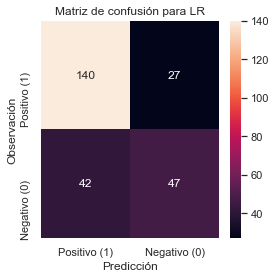

RF


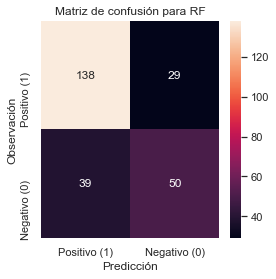

KNN


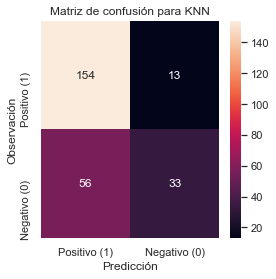

In [8]:
for model in model_summary:
    print(model[0])
    show_info_confusion_matrix(model[1], model[0])

###  Accuracy & F1-Score: Reporte de la clasificación
      
**Accuracy (Exactitud):** Es la medida de rendimiento mas simple e intuitiva, que hace referencia a una relación entre las observaciones correctamente predichas (VP+VN) y las totales (todos los resultados). Sin embargo, la exactitud no debe ser considerada una buena medida cuando la muestra no es simétrica o esta sesgada *(Como se vio en el grafico de distribución y balance de la varaible objetivo)*, en otras palabras, no se expresa la afinidad y la implicación de las tasas de falsos positivos y negativos.

        F1 = VP+VN / VP+VN+FN+FP

**F1 Score:** Esta métrica es el promedio ponderado entre la precisión y la sensibilidad. Por lo tanto, cuando el costo o distribución de los falsos positivos y los falsos negativos es muy diferentes, F1 es una de las mejores medidas para evaluar y comparar clasificadores.

        F1 = 2 x (precision x recall)/(precision + recall)
        
> ***Precisión*** - Esta métrica es la relación que existe entre las observaciones positivas predichas correctamente y las observaciones positivas predichas totales, lo que significa que una alta precisión denota un tasa de falsos positivos baja.
> 
> Precision = VP/VP+FP
> 
> ***Sensibilidad (Recall)*** - Hace referencia a la razón entre las observaciones positivas correctamente predichas y todas las observaciones en la clase real, dando respuesta a cuantos de los valores verdaderos de una clases se predijeron adecuadamente.
> 
> Recall = VP/VP+FN


![](https://miro.medium.com/max/1400/1*LYdQZjwu4CnovJeh_K1xGQ.png)
        
Más Información: 
- http://joshlawman.com/metrics-classification-report-breakdown-precision-recall-f1/
- https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

In [9]:
for model in model_summary:
    print(model[0])
    print('Accuracy: '+str(model[3]))
    print('F1-Score: '+str(model[4]))
    print(model[2])

LR
Accuracy: 0.73046875
F1-Score: 0.7238592242076398
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       167
           1       0.64      0.53      0.58        89

   micro avg       0.73      0.73      0.73       256
   macro avg       0.70      0.68      0.69       256
weighted avg       0.72      0.73      0.72       256

RF
Accuracy: 0.734375
F1-Score: 0.7303303225359912
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       167
           1       0.63      0.56      0.60        89

   micro avg       0.73      0.73      0.73       256
   macro avg       0.71      0.69      0.70       256
weighted avg       0.73      0.73      0.73       256

KNN
Accuracy: 0.73046875
F1-Score: 0.702914548334807
              precision    recall  f1-score   support

           0       0.73      0.92      0.82       167
           1       0.72      0.37      0.49        89

   micro avg       0.73  

### ROC - AUC
La curva ROC (Característica Operativa del Receptor) Representa la tasa de verdaderos positivos frente a la tasa de falsos
positivos bajo un umbral de clasificación, lo que nos dice qué tan bueno puede distinguir el modelo entre dos cosas (por ejemplo, si un paciente tiene una enfermedad o no). AUC no es mas que el área bajo la curva ROC

Mas información (video): https://www.youtube.com/watch?v=OAl6eAyP-yo

In [10]:
def plot_roc(fpr,tpr,title):
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr, label='Knn')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve for '+title)
    plt.show()

LR
AUC: 0.8266164300612259


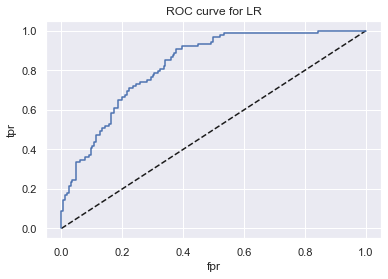

RF
AUC: 0.8180380811410887


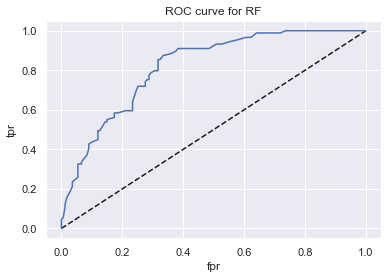

KNN
AUC: 0.7298324698916774


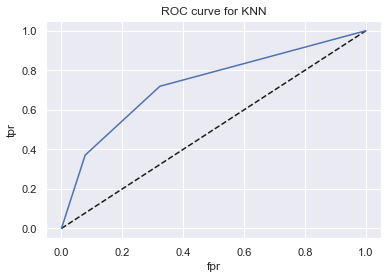

In [11]:
for model in model_summary:
    print(model[0])
    print('AUC: '+str(model[5]['roc']))
    plot_roc(model[5]['fpr'],model[5]['tpr'],model[0])

## Optimización - Hyperparametros
**Caso de uso: Mejorar los desempeños de KNN a partir de GridSearch y K-fold Cross Validation**

**K-fold Cross Validation** la validación cruzada por K-fold, es aquella explicada anteriormente, donde se hace K numero de iteraciones, con diferentes datos para entrenamiento y validación, y se selecciona la mejor combinación.

**GridSearch** la una búsqueda por cuadrícula es un enfoque para el ajuste de hiperparámetros que construirá y evaluará metódicamente un modelo para cada combinación de parámetros de algoritmo especificados en una cuadrícula.

Consideremos el siguiente ejemplo:

Supongamos que un modelo de aprendizaje automático X toma hiperparámetros a1, a2 y a3. En la búsqueda por cuadrícula, se define el rango de posibles valores para cada uno de los hiperparámetros a1, a2 y a3. Esto es como una matriz de valores para cada uno de los hiperparámetros. Ahora, la técnica de búsqueda de cuadrícula construirá muchas versiones de X con todas las combinatorias posibles de valores (a1, a2 y a3) que definió en primer lugar. Este rango de valores de hiperparámetro se denomina cuadrícula.

Supongamos que definió la cuadrícula como:
- a1 = [0,1,2,3,4,5]
- a2 = [10,20,30,40,5,60]
- a3 = [105,105,110,115,120,125]

El algoritmo comenzará con la combinación de [0,10,105], y terminará con [5,60,125]. Pasará por todas las combinaciones intermedias entre estos dos, esto hace que la búsqueda por cuadrícula sea muy costosa computacionalmente.

In [12]:
#In el caso de KNN el parametro ajustable es el numero de vecinos (n_neighbors)
param_grid = {'n_neighbors':np.arange(1,50)} # de 1 a 50 vecinos

knn = KNeighborsClassifier()

# El algoritmo tendra que correr 50 veces (numero de vecinos) * 5 veces (k iteraciones de validacion cruzada) = 250 veces
# Seleccionado Accuracy como metrica de evaluación y comparación.
knn_cv= GridSearchCV(knn,param_grid,cv=5, scoring='accuracy')
knn_cv.fit(X_train,y_train)

print("Mejores Desempeños:" + str(knn_cv.best_score_))
print("Mejores Parametros: " + str(knn_cv.best_params_))

Mejores Desempeños:0.787109375
Mejores Parametros: {'n_neighbors': 14}


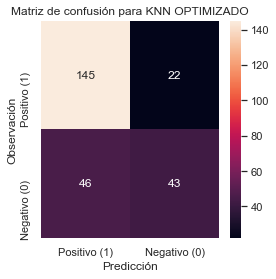

Accuracy: 0.734375
F1: 0.7225805793368643
ROC: 0.8215367018771446


In [13]:
# Resultados para Test
preds = knn_cv.predict(X_test)
# Resultados guardados
show_info_confusion_matrix(confusion_matrix(y_test,preds), 'Knn Optimizado')
print('Accuracy: '+ str(accuracy_score(y_test,preds)))
print('F1: '+ str(f1_score(y_test,preds,average='weighted')))
print('ROC: '+ str(roc_auc_score(y_test,knn_cv.predict_proba(X_test)[:,1])))

## Usar el predictor
En la mayoría de articulos técnicos y libros, el proceso termina cuando se encuentra un valor Accuracy adecuado. Cuando uno inicia con aprendizaje de máquinas quiere realizar pruebas y obtener predictores. Para finalizar, vamos a crear un vector que represente los datos de un (1) paciente y buscar la predicción.

In [14]:
#parametros que espera el modelo predictor
X = X_test.sample(1)
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
672,1.827813,-1.765076,2.77908,-0.695245,-1.061917,0.443156,-0.564389,1.170732


In [17]:
X = X_test.sample(1)
# Evaluación de resultados y metricas
model_summary = []
for name,model in zip(model_index,model_sklearn):
    # Predicción con el conjunto de datos de prueba
    probability_class_1 = model.predict_proba(X)[:, 1]
    probability_class_0 = model.predict_proba(X)[:, 0]
    
    if probability_class_1 >= probability_class_0:
        resultado ='ENFERMO'
    else:
        resultado = 'SANO'
    
    # Predicción por modelo
    print('Predicción con el modelo ', name, ' es ', resultado,' con probabilidad sano ', probability_class_0, 
          ' y de enfermo ',probability_class_1)


Predicción con el modelo  LR  es  ENFERMO  con probabilidad sano  [0.13541649]  y de enfermo  [0.86458351]
Predicción con el modelo  RF  es  ENFERMO  con probabilidad sano  [0.12]  y de enfermo  [0.88]
Predicción con el modelo  KNN  es  ENFERMO  con probabilidad sano  [0.]  y de enfermo  [1.]


## Fin etapa de modelamiento e interpretación

El aprendizaje de máquinas es un proceso riguroso y completo, que requiere un entendimiento profundo de las variables, correlaciones y resultados. No basta con buscar "buenas cifras" en los parámetros de evaluación; es preciso ahondar y entender claramente qué hace cada modelo y cómo lo hace, para dar resultados fiables. Es preciso recodar que en el mundo clínico, es necesaria la rigurosidad en los procesos. 

¡La práctica hace al maestro!